## 1. Dataset Preparation

### 1.1 Data Annotation

In [2]:
import kagglehub
import os
from pathlib import Path
import pandas as pd

os.environ['KAGGLEHUB_CACHE'] = str(Path.cwd() / "data") # Set cache directory to ./data

data_root_dir = kagglehub.dataset_download("tongpython/cat-and-dog")
print("Path to dataset cache:", data_root_dir)
train_cat_dir = Path(data_root_dir) / "training_set" / "training_set" / "cats"
train_dog_dir = Path(data_root_dir) / "training_set" / "training_set" / "dogs"
val_cat_dir = Path(data_root_dir) / "test_set" / "test_set" / "cats"
val_dog_dir = Path(data_root_dir) / "test_set" / "test_set" / "dogs"
# Glob training files
train_cat_files = list(train_cat_dir.glob("**/*.jpg"))
train_dog_files = list(train_dog_dir.glob("**/*.jpg"))
print(f"There are {len(train_cat_files)} cat images, and {len(train_dog_files)} dog images in the training dataset")
df_train = pd.DataFrame({
    'path': list(train_cat_files) + list(train_dog_files),
    'label': ['cat'] * len(list(train_cat_files)) + ['dog'] * len(list(train_dog_files))
})
df_train.to_csv('annotations_train.csv', header=False, index=False)  

# Glob validation files
val_cat_files = list(val_cat_dir.glob("**/*.jpg"))
val_dog_files = list(val_dog_dir.glob("**/*.jpg"))
print(f"There are {len(val_cat_files)} cat images, and {len(val_dog_files)} dog images in the validation dataset")
df_val = pd.DataFrame({
    'path': list(val_cat_files) + list(val_dog_files),
    'label': ['cat'] * len(list(val_cat_files)) + ['dog'] * len(list(val_dog_files))
})
df_val.to_csv('annotations_val.csv', header=False, index=False)  

/home/pbd0/Documents/3321/3321tpl-cat_vs_dog-mlp/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset cache: /home/pbd0/Documents/3321/3321tpl-cat_vs_dog-mlp/data/datasets/tongpython/cat-and-dog/versions/1
There are 4000 cat images, and 4005 dog images in the training dataset
There are 1011 cat images, and 1012 dog images in the validation dataset


### 1.2 PyTorch Dataset Creation


In [3]:
from torchvision.io import decode_image, ImageReadMode
from torchvision.transforms.v2 import Resize
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(3321)

class CatDogDataset(Dataset):
    def __init__(self, annotations_file):
        self.imgs_info = pd.read_csv(annotations_file, header=None)

    def __len__(self):
        return len(self.imgs_info)
    
    def __getitem__(self, idx):
        img_path = self.imgs_info.iloc[idx, 0]
        raw_img = decode_image(img_path, mode=ImageReadMode.RGB)
        # resize image to (64, 64)
        image = Resize((64, 64))(raw_img)
        category = 1. if self.imgs_info.iloc[idx, 1] == 'dog' else 0.
        sample = {'image': image, 'category': category}

        return sample

### 1.3 Data Pre-Processing


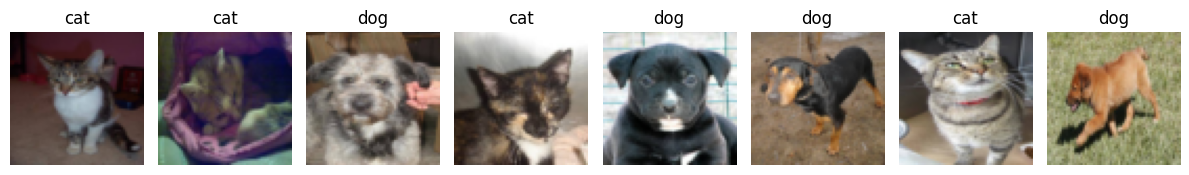

In [7]:
# Extract features/images and targets/labels
dataset_train = CatDogDataset(annotations_file='annotations_train.csv')
dataset_val = CatDogDataset(annotations_file='annotations_val.csv')

# Create data loaders
dataloader_train = DataLoader(dataset_train, batch_size=256, shuffle=True)  # large batch size to get all data in one batch
dataloader_val = DataLoader(dataset_val, batch_size=256, shuffle=False)
# Extract all data from dataloaders
raw_data_train = next(iter(dataloader_train))
raw_data_val = next(iter(dataloader_val))

# Separate features from targets 
raw_features_train = raw_data_train['image'].numpy()
raw_labels_train = raw_data_train['category'].numpy()
raw_features_val = raw_data_val['image'].numpy()
raw_labels_val = raw_data_val['category'].numpy()
# Uncomment 4 lines below to exam the raw data
# print(f"Raw training features shape: {raw_features_train.shape}, raw trainging labels shape: {raw_labels_train.shape}")
# print(f"Raw validation features shape: {raw_features_val.shape}, raw validation labels shape: {raw_labels_val.shape}")
# print(f"A sample of raw features array:\n {raw_features_train[0]}")
# print(f"First 10 raw training labels: {raw_labels_train[:10]}")

# Visualize a few sample images
fig, axs = plt.subplots(1, 8, figsize=(12, 6))
for i in range(8):
    sample_img = raw_features_train[i]
    sample_cls = raw_labels_train[i]
    axs[i] = plt.subplot(1, 8, i + 1)
    axs[i].set_title(f'{"dog" if sample_cls == 1. else "cat"}')
    axs[i].axis('off')
    axs[i].imshow(np.transpose(sample_img, (1, 2, 0)))  # image is already in (H, W, C) format
    plt.tight_layout()

# Rerun this cell to get different samples.